In [4]:
from sklearn.datasets import load_svmlight_file
from scipy.sparse import isspmatrix_csc, isspmatrix_csr
from joblib import Memory
import numpy as np


DIR = "./datasets/"

# Dataset source: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w1a
W1A = DIR + "w1a"
W1A_FEATURES = 300

# Cache the read datasets so they are loaded faster
# on subsequent program runs
mem = Memory("./cache")

@mem.cache
def get_data(filepath, n_features, dtype):
    data = load_svmlight_file(filepath, n_features, dtype)
    return data[0], data[1]

X, y = get_data(W1A, W1A_FEATURES, np.int32)

In [10]:
from functools import partial

# X (n, p) 
# y (n)
# beta (p, 1) the weights of the logistic loss
def logloss_gradient(X, y, beta):
    # n number of samples
    # p number of features
    n, p = X.shape
    w = np.ones((n, 1))

    # yi = i-th sample's label
    # xi = i-th sample -> (1, p)
    for i in range(n):
        exp = np.exp(-y[i] * X[i].dot(beta))

        w[i] = -y[i] * (exp / (1 + exp))

    return (1 / n) * X.transpose().dot(w)


# Compute the partial gradient for the j-th component
def logloss_partial_grad(X, y, beta, j):
    # n number of samples
    n, _ = X.shape

    grad = 0

    for i in range(n):
        exp = np.exp(-y[i] * X[i].dot(beta))

        grad += ((1 / (1 + exp)) - 1) * (y[i] * X[i][j])

    return (1 / n) * grad


def logloss(X, y, beta):
    n, p = X.shape
    sum = 0

    for i in range(n):
        sum += np.log(1 + np.exp(-y[i] * X[i].dot(beta)))

    return (1 / n) * sum

[[ 0.01352442]
 [ 0.01190957]
 [ 0.01917642]
 [ 0.01534114]
 [ 0.01756157]
 [ 0.01332257]
 [ 0.01937828]
 [ 0.01453371]
 [ 0.01150585]
 [ 0.02180057]
 [ 0.01574485]
 [ 0.01655228]
 [ 0.01453371]
 [ 0.01473557]
 [ 0.015543  ]
 [ 0.02664514]
 [ 0.01332257]
 [ 0.01574485]
 [ 0.02442471]
 [ 0.02422285]
 [ 0.02180057]
 [ 0.01251514]
 [ 0.02018571]
 [ 0.01655228]
 [ 0.01675414]
 [ 0.01735971]
 [ 0.01392814]
 [ 0.01574485]
 [ 0.015543  ]
 [ 0.01251514]
 [ 0.01655228]
 [ 0.01655228]
 [ 0.01433185]
 [ 0.01614857]
 [ 0.10375454]
 [ 0.00100929]
 [ 0.04097699]
 [ 0.0668147 ]
 [-0.00060557]
 [ 0.        ]
 [ 0.00383528]
 [-0.00040371]
 [-0.00040371]
 [ 0.03027856]
 [ 0.02543399]
 [ 0.00020186]
 [ 0.03249899]
 [ 0.00080743]
 [ 0.        ]
 [ 0.02503028]
 [ 0.02079128]
 [ 0.00020186]
 [ 0.00968914]
 [ 0.07791683]
 [ 0.09568026]
 [ 0.00080743]
 [ 0.07488898]
 [ 0.        ]
 [ 0.03794913]
 [ 0.00262414]
 [-0.00020186]
 [ 0.03613242]
 [ 0.00080743]
 [-0.00020186]
 [ 0.00181671]
 [ 0.        ]
 [-0.00040

In [23]:
from random import randint

EPSILON = 0.000001

# Accelerated coordinate descent framework for the miu strongly convex case
# x0 - initial values for the loss function weights, size (n, 1)
# iter number of iterations
# gradient the function that computes the full gradient for a parameter gradient(beta)
# partial_gradient the function that computes a partial derivative for coord j and beta partial_gradient(beta, j)
# coord1 and coord2 are functions that take in (L, full_gradient) as params and return the chosen coords
def miu_strong_acc_cd(x0, miu, iter, gradient, partial_gradient, coord1, coord2, report_progress, L=None):
    n, _ = x0.shape

    a = np.sqrt(miu) / (n + np.sqrt(miu))
    b = (miu * a) / (n * n)

    if L is None:
        # generate initial non-zero vector of Lipschitz constants
        L = 1 / (np.random.rand(p, 1) + EPSILON)

    # both coord selection methods are greedy
    is_agcd = coord1 is coord2 and coord1 is greedy_choice
    # both coord select meth are random uniform
    is_arcd = coord1 is coord2 and coord1 is uniform_choice

    # z0 = x0
    zprev = x0
    xprev = x0

    for k in range(iter + 1):
        # report progress every 100 iterations
        if k % 100 == 0:
            report_progress(k, iter, xprev)

        yk = (1 - a) * xprev + a * zprev

        # do not compute the full gradient for arcd
        # only the partial gradient for a coordinate is needed
        if is_arcd:
            full_grad = None
        else:
            full_grad = gradient(yk)

        jk1 = coord1(L, full_grad)
        ejk1 = np.zeros((n, 1))
        ejk1[jk1] = 1

        # the full gradient is not needed for ARCD
        if is_arcd:
            Djk1 = partial_gradient(yk, jk1)
        else:
            Djk1 = full_grad[jk1]

        xnext = yk - (1 / L[jk1]) * Djk1  * ejk1
        uprev = ((a * a) / (a * a + b)) * zprev + (b / (a * a + b)) * yk

        # reuse allocated ejk1
        ejk2 = ejk1

        # don't compute the argmin again for agcd
        if is_agcd:
            jk2 = jk1
        else:
            jk2 = coord2(L, full_grad)
            ejk2[jk1] = 0
            ejk2[jk2] = 1

        
        # the full gradient is not needed for ARCD
        if is_arcd:
            Djk2 = partial_gradient(yk, jk2)
        else:
            Djk2 = full_grad[jk2]

        znext = uprev - (a / (a * a + b)) * (1 / (n * L[jk2])) * Djk2 * ejk2

        zprev = znext
        xprev = xnext

    return xnext


# rules functions used by the accelerated coord descent fw above:

# choose a coordinate uniformly for the randomized cd / semi-greedy cd
def uniform_choice(L, full_gradient):
    n, _ = L.shape

    return randint(0, n - 1)


def greedy_choice(L, full_gradient):
    gsl = (1 / np.sqrt(L)) * np.abs(full_gradient)

    return np.argmax(gsl)

iterations: 0 / 10000
iterations: 100 / 10000
iterations: 200 / 10000
iterations: 300 / 10000
iterations: 400 / 10000
iterations: 500 / 10000
iterations: 600 / 10000
iterations: 700 / 10000
iterations: 800 / 10000
iterations: 900 / 10000
iterations: 1000 / 10000
iterations: 1100 / 10000
iterations: 1200 / 10000
iterations: 1300 / 10000
iterations: 1400 / 10000
iterations: 1500 / 10000
iterations: 1600 / 10000
iterations: 1700 / 10000
iterations: 1800 / 10000
iterations: 1900 / 10000
iterations: 2000 / 10000
iterations: 2100 / 10000
iterations: 2200 / 10000
iterations: 2300 / 10000
iterations: 2400 / 10000
iterations: 2500 / 10000
iterations: 2600 / 10000
iterations: 2700 / 10000
iterations: 2800 / 10000
iterations: 2900 / 10000
iterations: 3000 / 10000
iterations: 3100 / 10000
iterations: 3200 / 10000
iterations: 3300 / 10000
iterations: 3400 / 10000
iterations: 3500 / 10000
iterations: 3600 / 10000
iterations: 3700 / 10000
iterations: 3800 / 10000
iterations: 3900 / 10000
iterations: 

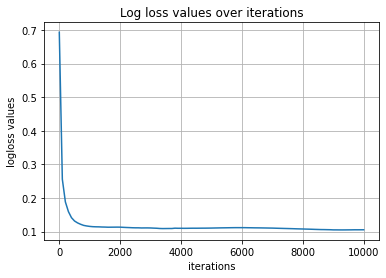

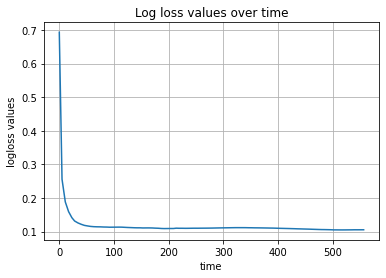

iterations: 0 / 10000
iterations: 100 / 10000
iterations: 200 / 10000
iterations: 300 / 10000
iterations: 400 / 10000
iterations: 500 / 10000
iterations: 600 / 10000
iterations: 700 / 10000
iterations: 800 / 10000
iterations: 900 / 10000
iterations: 1000 / 10000
iterations: 1100 / 10000
iterations: 1200 / 10000
iterations: 1300 / 10000
iterations: 1400 / 10000
iterations: 1500 / 10000
iterations: 1600 / 10000
iterations: 1700 / 10000
iterations: 1800 / 10000
iterations: 1900 / 10000
iterations: 2000 / 10000
iterations: 2100 / 10000
iterations: 2200 / 10000
iterations: 2300 / 10000
iterations: 2400 / 10000
iterations: 2500 / 10000
iterations: 2600 / 10000
iterations: 2700 / 10000
iterations: 2800 / 10000
iterations: 2900 / 10000
iterations: 3000 / 10000
iterations: 3100 / 10000
iterations: 3200 / 10000
iterations: 3300 / 10000
iterations: 3400 / 10000
iterations: 3500 / 10000
iterations: 3600 / 10000
iterations: 3700 / 10000
iterations: 3800 / 10000
iterations: 3900 / 10000
iterations: 

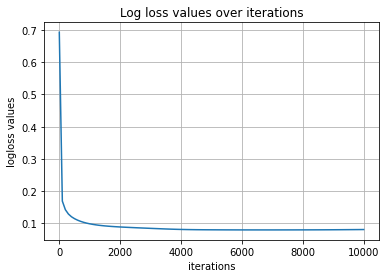

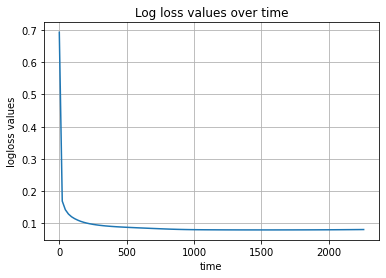

In [26]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

n, p = X.shape
# initial weight of the loss function
beta = np.zeros((p, 1))

X_nonsparse_array = X.toarray()

full_grad = partial(logloss_gradient, X, y)
partial_grad = partial(logloss_partial_grad, X_nonsparse_array, y)


# Compute the Lis constants for the logistic loss
# X_array non sparse matrix representation of the X matrix
# y the labels
def compute_logloss_Lis(X_array, y):
    n, p = X_array.shape
    L = np.zeros((p, 1))

    # zi = -yi * B.transpose * xi
    # e^(-zi) / (1 + e^(-zi)) ^ 2 <= 0.25
    for j in range(p):
        for i in range(n):
            L[j] += 0.25 * (y[i] * X_array[i][j]) ** 2

        L[j] = (1 / n) * L[j]
        # Offset Lis from 0
        L[j] += EPSILON

    return L


L = compute_logloss_Lis(X_nonsparse_array, y)
# print(L)


def plot_values(xs, ys, x_label, y_label, figure_title, figure_filename):
    fig, ax = plt.subplots()
    ax.plot(xs, ys)

    ax.set(xlabel=x_label, ylabel=y_label,
        title=figure_title)
    ax.grid()

    fig.savefig(figure_filename)
    plt.show()


# iters - number of iterations
# algo - the algorithm that is being run "agcd" or "ascd" or "arcd"
def run_logloss_coord_descent(iters, algo):
    array_size = int(iters / 100 + 1)
    logloss_values = np.zeros(array_size)
    # logloss values at intervals of time
    time_intervals = np.zeros(array_size)

    start_time = time.time()

    def report_progress(curr_iter, iters, curr_beta):
        print('iterations: %d / %d' % (curr_iter, iters))
        
        logloss_val = logloss(X, y, curr_beta)
        array_pos = int(curr_iter / 100)

        logloss_values[array_pos] = logloss_val
        time_intervals[array_pos] = int(time.time() - start_time)

    if algo == "agcd":
        beta_opt = miu_strong_acc_cd(beta, 1e-7, iters, full_grad, partial_grad, greedy_choice, greedy_choice, report_progress, L)
    elif algo == "ascd":
        beta_opt = miu_strong_acc_cd(beta, 1e-7, iters, full_grad, partial_grad, greedy_choice, uniform_choice, report_progress, L)
    elif algo == "arcd":
        beta_opt = miu_strong_acc_cd(beta, 1e-7, iters, full_grad, partial_grad, uniform_choice, uniform_choice, report_progress, L)
    else:
        return

    total_time = time.time() - start_time

    print(beta_opt)

    # Data for plotting
    xs_iters = np.arange(0, iters + 1, 100)
    xs_time = time_intervals
    ys = logloss_values

    plot_values(xs_iters, ys, 'iterations', 'logloss values', 'Log loss values over iterations', "logloss_%s_%s_iters.png" % (algo, iters))
    plot_values(xs_time, ys, 'time', 'logloss values', 'Log loss values over time', "logloss_%s_%s_%f.png" % (algo, iters, total_time))


run_logloss_coord_descent(10000, "arcd")
run_logloss_coord_descent(10000, "ascd")